In [1]:
import math
import MDAnalysis as mda
import numpy as np
from itertools import combinations
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
from scipy.spatial import KDTree
from scipy.spatial import Voronoi
from scipy.interpolate import splprep, splev

In [2]:
PDB = "/Users/michaelkrivan/Downloads/result/5afi-pdb-bundle2.pdb"
u = mda.Universe(PDB)

In [3]:
def parse_atom_token(tok):
    sel = u.select_atoms(f"resid {tok}")
    atoms = sel.atoms[0]
    return atoms.ix, atoms.position

def prompt_plane(label):
    print(f"3 atoms to define {label}. Enter residue id.")
    pick = []
    for i in range(1,4):
        tok = input(f"{label}, Res {i}:")
        idx, pos = parse_atom_token(tok)
        pick.append(pos)
    return pick

def create_plane(p1, p2, p3):
    v1, v2 = p2 - p1, p3 - p1
    n_n = np.cross(v1, v2)
    n_norm = np.linalg.norm(n_n)
    if n_norm == 0:
        raise ValueError("Colinear points; cannot define a plane.")
    n_unit = n_n / n_norm
    d = -np.dot(n_n, p1)
    centre = (p1 + p2 + p3) / 3.0
    return n_unit, d, centre

In [4]:
# Plane1: 2452, 2584, 2063 
# Plane2: 91, 1335, 492
pick1 = prompt_plane('Plane 1')
pick2 = prompt_plane('Plane 2')
P1 = create_plane(*pick1)
P2 = create_plane(*pick2)
endpoints = np.atleast_1d([P1[2],P2[2]])

3 atoms to define Plane 1. Enter residue id.


Plane 1, Res 1: 2452
Plane 1, Res 2: 2584
Plane 1, Res 3: 2063


3 atoms to define Plane 2. Enter residue id.


Plane 2, Res 1: 91
Plane 2, Res 2: 1335
Plane 2, Res 3: 492


In [5]:
def sample_tunnel(universe, endpoints, radius=20, n_samples=10):
    tunnel_axis = endpoints[1]-endpoints[0]
    tunnel_samples = [endpoints[0]+tunnel_axis*n/(n_samples-1) for n in range(n_samples)]
    selections = []
    for n in range(len(tunnel_samples)):
        sel = 'point '+' '.join([str(tunnel_samples[n][i]) for i in range(3)])+f' {radius}'
        selections.append(universe.select_atoms(sel))
    
    index = [*set(np.concatenate([selections[i].atoms.indices for i in range(n_samples)]))]
    return universe.atoms[index]
u_sel = sample_tunnel(u, endpoints)

In [6]:
def find_path(universe, endpoints):
    tree = KDTree(universe.atoms.positions)
    vor = Voronoi(universe.atoms.positions)
    V = vor.vertices
    edge_w = {}
    
    def cost_function(A,B,universe,alpha=10,sigma=1.2,r0=3):
        dist = np.linalg.norm(B-A)
        nn_d = [tree.query(pos,k=1)[0] for pos in [A,B,(A+B)/2]]
        delta = np.atleast_1d(nn_d).min() - r0
        cost = dist*(1+ alpha*math.exp(-delta/sigma))
        return cost
    
    for rv in vor.ridge_vertices:
            # Remove infinite vertices
            rv = [k for k in rv if k != -1]
            if len(rv) < 2:
                continue
    
            # Connect all pairs on this ridge face
            for i, j in combinations(rv, 2):
                if i == j:
                    continue
                a, b = (i, j) if i < j else (j, i)
                w = cost_function(V[a],V[b],universe)
                prev = edge_w.get((a, b))
                if prev is None or w < prev:
                    edge_w[(a, b)] = w

    # Find shortest path in the graph
    tree_vor = KDTree(V)
    idx_start = tree_vor.query(endpoints[0])[1]
    idx_end   = tree_vor.query(endpoints[1])[1]    
    rows, cols, data = [], [], []
    for (a, b), w in edge_w.items():
        rows += [a]
        cols += [b]
        data += [w]
    A = csr_matrix((data, (rows, cols)), shape=(len(V), len(V)))
    
    dist, pred = dijkstra(A, directed=False, indices=idx_start, return_predecessors=True)
    
    # Reconstruct the path
    path = []
    cur = idx_end
    while cur != idx_start:
        path.append(cur)
        cur = int(pred[cur])
    path.append(idx_start)
    path.reverse()
    tunnel_path = vor.vertices[path]
                        
    return tunnel_path

In [7]:
tunnel_path = find_path(u_sel, endpoints)

In [42]:
def clean_polyline(axis, eps=1e-8):
    axis = np.asarray(axis, float)
    keep = [0]
    for i in range(1, len(axis)):
        if np.linalg.norm(axis[i] - axis[keep[-1]]) > eps:
            keep.append(i)
    axis2 = axis[keep]
    return axis2

def smooth_axis(axis, step, smooth=1, n_samples=None):
    #axis = clean_polyline(axis)
    
    d = np.linalg.norm(axis[1:] - axis[:-1], axis=1)
    u = np.concatenate(([0.0], np.cumsum(d)))
    u /= u[-1]  # normalize to [0,1]
    
    # Fit a smoothing spline in 3D
    tck, _ = splprep(axis.T, u=u, s=smooth, k=3)
    
    u_dense = np.linspace(0, 1, 5000)
    xyz_dense = np.vstack(splev(u_dense, tck)).T
    ds = np.linalg.norm(xyz_dense[1:] - xyz_dense[:-1], axis=1)
    s_dense = np.concatenate(([0.0], np.cumsum(ds)))
    total_len = s_dense[-1]

    n_samples = int(np.ceil(total_len / step)) + 1

    # Arc-length resampling: target s positions
    s_target = np.linspace(0, total_len, n_samples)

    # Invert s(u) approximately via interpolation
    u_target = np.interp(s_target, s_dense, u_dense)

    axis_new = np.vstack(splev(u_target, tck)).T

    # Tangent vectors
    seg = axis_new[1:] - axis_new[:-1]
    seg_len = np.linalg.norm(seg, axis=1, keepdims=True)
    t_seg = seg / np.maximum(seg_len, 1e-12)

    return axis_new, t_seg, total_len

axis, t, length = smooth_axis(tunnel_path, smooth=2, step=0.3)

In [43]:
# Creating tunnel profile and selection of the lining atoms
def fit_sphere(points, center):
    P = np.asarray(points, float)
    c = np.asarray(center, float)
    d = np.linalg.norm(P - c[None, :], axis=1)
    return float(np.sqrt((d * d).mean()))

def sel_tunnel_atoms(universe, axis, sphere_radii, beta=4):
    selections = []
    for n in range(len(axis)):
        sel = 'point '+' '.join([str(axis[n][i]) for i in range(3)])+' '+str(sphere_radii[n]+beta)
        selections.append(universe.select_atoms(sel))
    
    tunnel_atoms = universe.atoms[list(set(np.concatenate(
        [selections[i].atoms.ix for i in range(len(selections))]
    )))]
    return tunnel_atoms

tree = KDTree(u_sel.atoms.positions)
sphere_radii = [fit_sphere(u_sel.atoms[tree.query(axis[i], k=3)[1]].positions, axis[i]) for i in range(len(axis))]
tunnel_atoms = sel_tunnel_atoms(u, axis, sphere_radii)

In [46]:
# Rotation minimizing frames along tunnel axis
def rot_min_frame(t):
    basis = [[1,0,0],[0,1,0],[0,0,1]]
    x = np.asarray([np.dot(v,t[0]) for v in basis])
    for i in range(3):
        if abs(x)[i] == min(abs(x)):
            a = i
    n0 = basis[a] - np.dot(t[0],basis[a])*t[0]
    b0 = np.cross(n0,t[0])
    n = np.zeros((len(t),3), float) 
    b = np.zeros((len(t),3), float)
    n[0] = n0
    b[0] = b0

    for i in range(1,len(t)):
        ti_p = t[i-1]
        ti = t[i]
        ni_p = n[i-1]
        
        v = np.cross(ti_p,ti)
        s = np.linalg.norm(v)
        c = np.clip(np.dot(ti,ti_p), -1.0, 1.0)
        
        k = v/s
        angle = np.arctan2(s,c)
        ni = (ni_p*np.cos(angle) + np.cross(k, ni_p)*np.sin(angle) +k*np.dot(k,ni_p)*(1-np.cos(angle)))
    
        ni = ni - np.dot(ni,ti)*ti
        ni = ni/np.linalg.norm(ni)
        bi = np.cross(ti,ni)
        
        n[i] = ni
        b[i] = bi
    return n, b
n, b = rot_min_frame(t)

In [47]:
def map_to_cyl(axis, points, t, n, b):
    K = t.shape[0]
    N = points.shape[0]
    Axis = axis[:-1]
    tt = np.sum(t*t, axis=1)
    L = np.sqrt(tt)
    S = np.concatenate(([0,0],np.cumsum(L)))

    best_d2 = np.full(N, np.inf)           #squared distance of the atom-tunnel path vertex
    best_seg = np.zeros(N, dtype=np.int32) #which segment best fits given atom
    best_u = np.zeros(N, dtype=float)      #length along found segment (0,1)
    best_Q = np.zeros((N,3), dtype=float)  #tunnel_path vertices

    for i in range(K-1):
        Ai=Axis[i]
        ti=t[i]
        denom = tt[i] if tt[i] > 0 else 1.0
        
        AP = points - Ai
        ui = (AP@ti)/denom
        ui = np.clip(ui,0,1)
        Qi = Ai + ui[:, None]*ti
        d2 = np.sum((points-Qi)**2, axis=1)
    
        mask = d2 < best_d2
        if np.any(mask):
            best_d2[mask] = d2[mask]
            best_seg[mask] = i
            best_u[mask] = ui[mask]
            best_Q[mask] = Qi[mask]
    r = np.sqrt(best_d2)
    s = S[best_seg] + best_u*L[best_seg]

    idx_right = np.searchsorted(S, s, side="left")
    idx_left  = np.clip(idx_right - 1, 0, len(S)-1)
    idx_right = np.clip(idx_right,     0, len(S)-1)

    vertex_id = np.where(
        np.abs(S[idx_right] - s) < np.abs(S[idx_left] - s),
        idx_right, idx_left
    ).astype(np.int32)
    
    t_v = np.zeros((K+1,3), dtype=float)
    n_v = np.zeros((K+1,3), dtype=float)
    b_v = np.zeros((K+1,3), dtype=float)
    t_v[0], n_v[0], b_v[0] = t[0], n[0], b[0]
    t_v[-1], n_v[-1], b_v[-1] = t[-1], n[-1], b[-1]
    for i in range(1, K):
        tv = t[i-1] + t[i]
        tv /= np.linalg.norm(tv)
        nv = n[i-1]
        nv -= np.dot(nv, tv) * tv
        nv /= np.linalg.norm(nv)
        bv = np.cross(tv, nv)
        t_v[i], n_v[i], b_v[i] = tv, nv, bv
    vid = vertex_id
    tv = t_v[vid]
    nv = n_v[vid]
    bv = b_v[vid]

    w = points - best_Q 
    w_perp = w - (np.sum(w*tv, axis=1)[:, None])*tv
    x = np.sum(w_perp*nv, axis=1)
    y = np.sum(w_perp*bv, axis=1)
    theta = np.arctan2(y,x)
    return s, theta, r

Z, Theta, R = map_to_cyl(axis, tunnel_atoms.positions, t, n, b)

In [56]:
import pandas as pd

sizes = np.interp(R, (R.min(), R.max()), (1000, 100))

df = pd.DataFrame({
    "Z": Z,
    "Theta": Theta,
    "ThetaDeg": Theta*180/3.14,
    "R": R,
    "Rinv": sizes,
    "Types": tunnel_atoms.types,
    "Chain": tunnel_atoms.chainIDs,
    "ResID": tunnel_atoms.resids
})

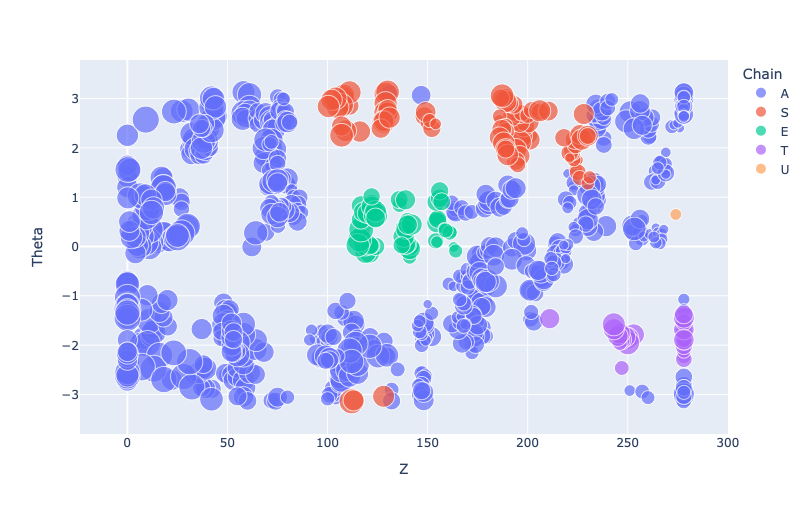

In [57]:
import plotly.express as px
fig = px.scatter(df, x="Z", y="Theta", color="Chain", size="Rinv", hover_data="ResID",
                width=1000,height=500)
fig.show()